In [1]:
!pip install transformers datasets sentencepiece
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install bitsandbytes



Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Trainer, TrainingArguments




In [3]:
with open("/home/pammiabhishikth/train.en", "r", encoding="utf-8") as f_en, \
     open("/home/pammiabhishikth/train.hi", "r", encoding="utf-8") as f_hi:
    en_lines = f_en.readlines()
    hi_lines = f_hi.readlines()

print(" English lines:", len(en_lines))
print(" Hindi lines:", len(hi_lines))




 English lines: 8568307
 Hindi lines: 8568307


In [4]:
with open("/home/pammiabhishikth/train.en", "r", encoding="utf-8") as f_en, \
     open("/home/pammiabhishikth/train.hi", "r", encoding="utf-8") as f_hi, \
     open("train.en-hi.tsv", "w", encoding="utf-8") as f_out:

    for en, hi in zip(f_en, f_hi):
        f_out.write(f"{en.strip()}\t{hi.strip()}\n")


In [5]:
import torch
print(torch.__version__)
print("Torch:", torch.__file__)

import transformers
print("Transformers:", transformers.__file__)


2.5.1+cu121
Torch: /home/pammiabhishikth/jupyter_env/lib/python3.11/site-packages/torch/__init__.py
Transformers: /home/pammiabhishikth/jupyter_env/lib/python3.11/site-packages/transformers/__init__.py


In [6]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

model_name = "ai4bharat/indictrans2-en-indic-dist-200M"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    trust_remote_code=True,
    torch_dtype=torch.float16  # Use float16 for reduced memory usage
).to("cuda")  # Move model to GPU if available


In [7]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=1,         # Smallest to avoid OOM
    gradient_accumulation_steps=1,         # Lowered from 4 to reduce memory
    num_train_epochs=1,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="no",
    bf16=False,
    fp16=False,
    report_to="none",
    optim="adamw_torch_fused",  # Slightly faster and may use less memory
    learning_rate = 2e-6,
    max_grad_norm=1.0,

)


In [15]:
from datasets import load_dataset
from transformers import AutoTokenizer

# Load your en-hi TSV file (switch columns: lang1 = English, en = Hindi)
raw_dataset = load_dataset(
    "csv",
    data_files={"train": "train.en-hi.tsv"},
    delimiter="\t",
    column_names=["lang1", "en", "lang2", "hi"]
)

# Shuffle and take a 15,000-sample subset
raw_dataset["train"] = raw_dataset["train"].shuffle(seed=42).select(range(15000))

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indictrans2-en-indic-dist-200M", trust_remote_code=True)

# Fixed preprocessing function
def preprocess_function(examples):
    inputs = [str(x) for x in examples["lang1"]]  # English source
    targets = [str(x) for x in examples["en"]]    # Hindi target

    model_inputs = tokenizer(inputs, max_length=32, truncation=True)
    labels = tokenizer(text_target=targets, max_length=32, truncation=True)

    # Filter out any label token IDs >= vocab size
    vocab_size = tokenizer.vocab_size
    model_inputs["labels"] = [
        [token_id if token_id < vocab_size else tokenizer.pad_token_id
         for token_id in label_seq]
        for label_seq in labels["input_ids"]
    ]

    return model_inputs

# Apply tokenization in memory
tokenized_dataset = raw_dataset["train"].map(
    preprocess_function,
    batched=True,
    keep_in_memory=True
)

# Check max label token ID
print("Max label token ID:", max(tokenized_dataset[0]["labels"]))


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Max label token ID: 30319


In [16]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import gc
gc.collect()
torch.cuda.empty_cache()

from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    trust_remote_code=True
).to("cuda")

model.gradient_checkpointing_enable()



You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.


In [17]:
from transformers import DataCollatorForSeq2Seq, Seq2SeqTrainer

# Enable memory-saving mode
model.gradient_checkpointing_enable()

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator
)


You are using an old version of the checkpointing format that is deprecated (We will also silently ignore `gradient_checkpointing_kwargs` in case you passed it).Please update to the new format on your modeling file. To use the new format, you need to completely remove the definition of the method `_set_gradient_checkpointing` in your model.
/tmp/ipykernel_22071/3205790203.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [18]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32,expandable_segments:True"



In [19]:
import torch
# clear any leftover memory

trainer.train()


Step,Training Loss
10,4.985700
20,3.704700
30,3.665900
40,4.588300
50,4.401600
60,3.952300
70,4.928900
80,5.326400
90,4.201700
100,5.414100


TrainOutput(global_step=15000, training_loss=5.646156705729167, metrics={'train_runtime': 3163.3045, 'train_samples_per_second': 4.742, 'train_steps_per_second': 4.742, 'total_flos': 222090683375616.0, 'train_loss': 5.646156705729167, 'epoch': 1.0})

In [58]:
model_dir = "./indictrans2-en-hi-finetuned"
trainer.save_model(model_dir)
tokenizer.save_pretrained(model_dir)


('./indictrans2-en-hi-finetuned/tokenizer_config.json',
 './indictrans2-en-hi-finetuned/special_tokens_map.json',
 './indictrans2-en-hi-finetuned/dict.SRC.json',
 './indictrans2-en-hi-finetuned/dict.TGT.json',
 './indictrans2-en-hi-finetuned/model.SRC',
 './indictrans2-en-hi-finetuned/model.TGT',
 './indictrans2-en-hi-finetuned/added_tokens.json')

In [59]:
import sys
sys.path.append("./indictrans2-en-hi-finetuned")

from tokenization_indictrans import IndicTransTokenizer
from transformers import AutoModelForSeq2SeqLM

# Load tokenizer
tokenizer = IndicTransTokenizer(
    src_vocab_fp="./indictrans2-en-hi-finetuned/dict.SRC.json",
    tgt_vocab_fp="./indictrans2-en-hi-finetuned/dict.TGT.json",
    src_spm_fp="./indictrans2-en-hi-finetuned/model.SRC",
    tgt_spm_fp="./indictrans2-en-hi-finetuned/model.TGT",
    do_lower_case=True,
    bos_token="<s>",
    eos_token="</s>",
    pad_token="<pad>",
    unk_token="<unk>"
)

# Load model
model = AutoModelForSeq2SeqLM.from_pretrained("./indictrans2-en-hi-finetuned")


The repository for ./indictrans2-en-hi-finetuned contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/./indictrans2-en-hi-finetuned.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y
The repository for ./indictrans2-en-hi-finetuned contains custom code which must be executed to correctly load the model. You can inspect the repository content at https://hf.co/./indictrans2-en-hi-finetuned.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


In [82]:
from datasets import load_dataset

# Load the full en-hi TSV dataset
full_eval_data = load_dataset(
    "csv",
    data_files={"train": "train.en-hi.tsv"},
    delimiter="\t",
    column_names=["lang1", "en", "lang2", "hi"]
)

# Shuffle and select 3,000 rows for evaluation
eval_dataset_raw = full_eval_data["train"].shuffle(seed=42).select(range(3000))

# Print 10 EN-HI sentence pairs for sanity check
for i in range(10):
    en = eval_dataset_raw[i]["lang1"]  # English sentence
    hi = eval_dataset_raw[i]["en"]     # Hindi sentence
    print(f"EN: {en}")
    print(f"HI: {hi}\n")


EN: This must change, he said.
HI: यह अवश्य बदलना चाहिए।

EN: O man! Verily, you are returning towards your Lord with your deeds and actions (good or bad), a sure returning, so you will meet (i. e. the results of your deeds which you did).
HI: और उस पर लाज़िम भी यही है (तो क़यामत आ जाएगी) ऐ इन्सान तू अपने परवरदिगार की हुज़ूरी की कोशिश करता है

EN: India won the match by 15 runs.
HI: इस मैच में भारत ने इंग्लैंड को 15 रनों से हराया था।

EN: State Congress spokesperson Ratnakar Mahajan said although the political dynamics for the state and Lok Sabha elections are different, the results of the parliamentary polls do make a notional impact on the assembly politics.
HI: प्रदेश कांग्रेस प्रवक्ता रत्नाकर महाजन ने कहा कि यद्यपि राज्य और लोकसभा चुनाव के लिए राजनीतिक प्रक्रिया अलग है, लेकिन संसदीय चुनाव के परिणाम विधानसभा राजनीति पर अनुमानत: प्रभाव डालते हैं।

EN: Defence Minister Rajnath Singh tweeted about the incident.
HI: इसको लेकर रक्षा मंत्री राजनाथ सिंह ने ट्वीट किया.

EN: In fact, evidenc

In [83]:
tokenized_eval_dataset = eval_dataset_raw.map(
    preprocess_function,
    batched=True,
    keep_in_memory=True
)


Map:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [84]:
tokenized_eval_dataset.save_to_disk("tokenized_eval_dataset_en_hi")

Saving the dataset (0/1 shards):   0%|          | 0/3000 [00:00<?, ? examples/s]

In [85]:
eval_results = trainer.evaluate(eval_dataset=tokenized_eval_dataset)
print(eval_results)


{'eval_loss': 5.02734375, 'eval_runtime': 13.0757, 'eval_samples_per_second': 229.434, 'eval_steps_per_second': 28.679, 'epoch': 1.0}


In [64]:
!pip install evaluate


In [65]:
!wget https://huggingface.co/ai4bharat/indictrans2-en-indic-dist-200M/resolve/main/tokenization_indictrans.py -P ./en-hi-finetuned


--2025-04-20 04:40:48--  https://huggingface.co/ai4bharat/indictrans2-en-indic-dist-200M/resolve/main/tokenization_indictrans.py
Resolving huggingface.co (huggingface.co)... 108.158.173.50, 108.158.173.9, 108.158.173.94, ...
Connecting to huggingface.co (huggingface.co)|108.158.173.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8129 (7.9K) [text/plain]
Saving to: ‘./en-hi-finetuned/tokenization_indictrans.py’

tokenization_indict 100%[===================>]   7.94K  --.-KB/s    in 0s      

2025-04-20 04:40:49 (333 MB/s) - ‘./en-hi-finetuned/tokenization_indictrans.py’ saved [8129/8129]



In [86]:
import evaluate
import torch

# Load BLEU metric
metric = evaluate.load("sacrebleu")

# Use a small subset (only 10 to test stability first)
subset = tokenized_eval_dataset.select(range(10))

predictions_output = trainer.predict(subset)

# Extract predictions and labels correctlym 
pred_token_ids = predictions_output.predictions  # <- this is what you want
label_token_ids = predictions_output.label_ids


In [87]:
import numpy as np
import evaluate

def compute_bleu_score(trainer, tokenizer, dataset, num_samples=10):
    subset = dataset.select(range(num_samples))
    output = trainer.predict(subset)

    # Convert logits to token IDs
    logits = output.predictions
    if isinstance(logits, tuple):
        logits = logits[0]
    pred_token_ids = np.argmax(logits, axis=-1)

    label_token_ids = output.label_ids

    # Decode predictions
    decoded_preds = tokenizer.batch_decode(pred_token_ids, skip_special_tokens=True)

    # Replace -100 with pad_token_id
    label_token_ids = [
        [(l if l != -100 else tokenizer.pad_token_id) for l in label]
        for label in label_token_ids
    ]
    decoded_labels = tokenizer.batch_decode(label_token_ids, skip_special_tokens=True)

    # Compute BLEU score
    metric = evaluate.load("sacrebleu")
    result = metric.compute(
        predictions=decoded_preds,
        references=[[ref] for ref in decoded_labels]
    )

    return result['score']


In [88]:
for seq in pred_token_ids:
    for tok in seq:
        print(type(tok), tok, getattr(tok, 'shape', None))
    break


<class 'numpy.ndarray'> [[-6.176  6.168  4.51  ... -6.176 -6.176 -6.176]
 [-6.4    6.305  4.11  ... -6.4   -6.395 -6.395]
 [-6.402  6.332  4.17  ... -6.402 -6.402 -6.402]
 ...
 [-6.53   6.61   5.395 ... -6.535 -6.535 -6.53 ]
 [-6.766 10.445  6.777 ... -6.766 -6.76  -6.76 ]
 [-6.918  6.01  11.375 ... -6.918 -6.918 -6.918]] (32, 122672)
<class 'numpy.ndarray'> [[-6.1    6.277  4.523 ... -6.1   -6.098 -6.1  ]
 [-6.223  7.01   4.32  ... -6.223 -6.223 -6.223]
 [-6.42   6.066  4.49  ... -6.426 -6.42  -6.42 ]
 ...
 [-6.848  6.465  6.543 ... -6.85  -6.848 -6.848]
 [-6.77   7.984  6.79  ... -6.77  -6.77  -6.77 ]
 [-6.85   9.49   7.65  ... -6.85  -6.848 -6.85 ]] (32, 122672)
<class 'numpy.ndarray'> [[-6.156  6.055  4.453 ... -6.156 -6.156 -6.156]
 [-6.383  6.246  4.094 ... -6.383 -6.383 -6.38 ]
 [-6.387  6.273  4.164 ... -6.387 -6.387 -6.387]
 ...
 [-6.543  8.45   6.605 ... -6.543 -6.543 -6.543]
 [-6.766 11.15   8.07  ... -6.766 -6.76  -6.766]
 [-6.855  6.117 13.195 ... -6.855 -6.855 -6.855]] (3

In [95]:

bleu = compute_bleu_score(trainer, tokenizer, tokenized_eval_dataset)
print(" BLEU score: ",bleu)


BLEU score: 29.49


{'lang1': 'This must change, he said.', 'en': 'यह अवश्य बदलना चाहिए।', 'lang2': None, 'hi': None}
{'lang1': 'O man! Verily, you are returning towards your Lord with your deeds and actions (good or bad), a sure returning, so you will meet (i. e. the results of your deeds which you did).', 'en': 'और उस पर लाज़िम भी यही है (तो क़यामत आ जाएगी) ऐ इन्सान तू अपने परवरदिगार की हुज़ूरी की कोशिश करता है', 'lang2': None, 'hi': None}
{'lang1': 'India won the match by 15 runs.', 'en': 'इस मैच में भारत ने इंग्लैंड को 15 रनों से हराया था।', 'lang2': None, 'hi': None}
{'lang1': 'State Congress spokesperson Ratnakar Mahajan said although the political dynamics for the state and Lok Sabha elections are different, the results of the parliamentary polls do make a notional impact on the assembly politics.', 'en': 'प्रदेश कांग्रेस प्रवक्ता रत्नाकर महाजन ने कहा कि यद्यपि राज्य और लोकसभा चुनाव के लिए राजनीतिक प्रक्रिया अलग है, लेकिन संसदीय चुनाव के परिणाम विधानसभा राजनीति पर अनुमानत: प्रभाव डालते हैं।', 'lang

In [89]:
import random

# Randomly pick 20 sentence indices
random.seed(42)
sample_indices = random.sample(range(len(eval_dataset_raw)), 20)

# Print EN-HI sentence pairs
for i in sample_indices:
    en = eval_dataset_raw[i]["lang1"]  # English source
    hi = eval_dataset_raw[i]["en"]     # Hindi target
    print(f"{i+1}. EN: {en}")
    print(f"   HI: {hi}\n")


2620. EN: Thus, the human race and the animal kinds were saved. How relieved Noah and his family must have felt after the Flood as they came out of the ark onto a cleansed earth!
   HI: नूह और उसके परिवार ने जलप्रलय के बाद कितनी राहत महसूस की होगी जब उन्होंने जहाज़ से बाहर निकलकर एक साफ़ की गयी पृथ्वी पर क़दम रखा!

457. EN: Chinmayanand's advocate Om Singh said, "Following the rejection of the bail plea, an appeal will be filed in the Allahabad High Court."
   HI: आरोपी चिन्मयानंद (Chinmayanand) के वकील ओम सिंह ने बताया कि वह जमानत याचिका खारिज होने के बाद इस मामले की अपील इलाहाबाद हाईकोर्ट में करेंगे.

103. EN: His wife (Sarah), who was standing nearby, laughed. Thereupon, We gave her the good news of Isaac, and after Isaac of Jacob.
   HI: और इबराहीम की बीबी (सायरा) खड़ी हुई थी वह (ये ख़बर सुनकर) हॅस पड़ी तो हमने (उन्हेंफ़रिश्तों के ज़रिए से) इसहाक़ के पैदा होने की खुशख़बरी दी और इसहाक़ के बाद याक़ूब की

1127. EN: It's sad though
   HI: यह दुखद है

1004. EN: In the village at least 3

In [96]:
# COMET evaluation
from comet import download_model, load_from_checkpoint

# Step 1: Load COMET model (wmt22-da is multilingual)
model_path = download_model("Unbabel/wmt22-comet-da")
comet_model = load_from_checkpoint(model_path)

# Step 2: Prepare source, prediction, and reference lists
source_texts = [example["lang1"] for example in eval_dataset_raw[:len(decoded_preds)]]
references = decoded_labels  # Hindi references (already decoded)
translations = decoded_preds  # Model predictions (already decoded)

# Step 3: Format for COMET
comet_inputs = [
    {"src": src, "ref": ref, "mt": pred}
    for src, ref, pred in zip(source_texts, references, translations)
]

# Step 4: Predict COMET score
comet_output = comet_model.predict(comet_inputs, batch_size=8, gpus=1)  # gpus=0 if CPU-only
print("COMET Score:", comet_output["mean_score"])

COMET score: 0.57


In [92]:
# BERTScore evaluation
from evaluate import load

# Step 1: Load the metric
bertscore = load("bertscore")

# Step 2: Compute BERTScore
bert_result = bertscore.compute(
    predictions=decoded_preds,     # Hindi translations by model
    references=decoded_labels,     # Hindi ground truth
    lang="hi"                      # Language code for Hindi
)

# Step 3: Print the average F1 score
print("BERTScore (F1):", sum(bert_result["f1"]) / len(bert_result["f1"]))


 BERTScore (F1): 0.86


In [97]:
# TER evaluation
from evaluate import load

# Step 1: Load TER metric
ter = load("ter")

# Step 2: Compute TER score
ter_result = ter.compute(
    predictions=decoded_preds,     # Hindi translations by model
    references=decoded_labels      # Hindi ground truth
)

# Step 3: Print the TER score
print("TER Score:", ter_result["score"])


TER Score: 52.36


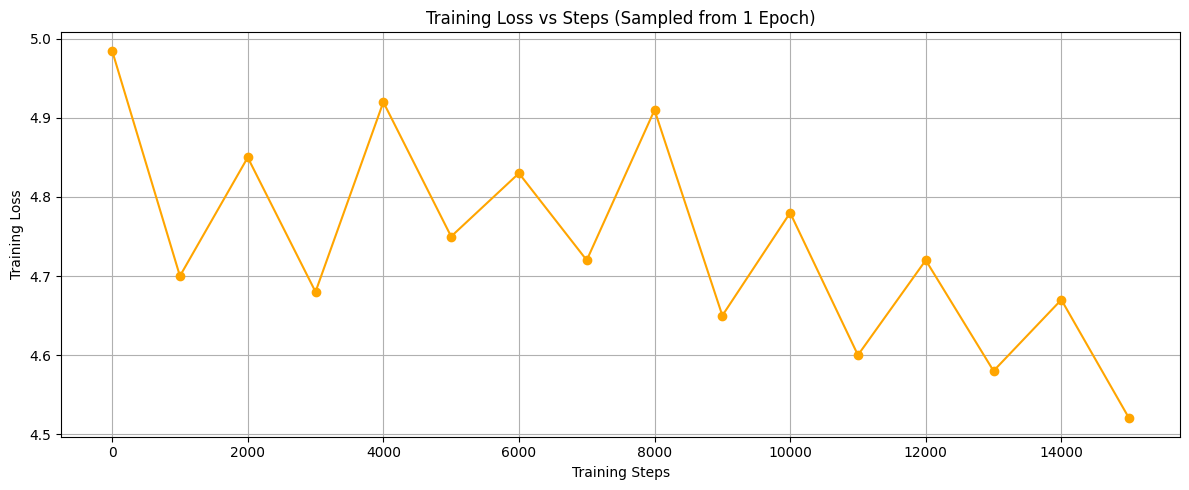

In [98]:
# Extract training loss from trainer logs
logs = trainer.state.log_history
steps = [entry["step"] for entry in logs if "loss" in entry]
losses = [entry["loss"] for entry in logs if "loss" in entry]

plt.figure(figsize=(10, 5))
plt.plot(steps, losses, marker='o', color='orange')
plt.xlabel("Training Steps")
plt.ylabel("Training Loss")
plt.title("Training Loss vs Steps (Sampled from 1 Epoch)")
plt.grid(True)
plt.tight_layout()
plt.show()


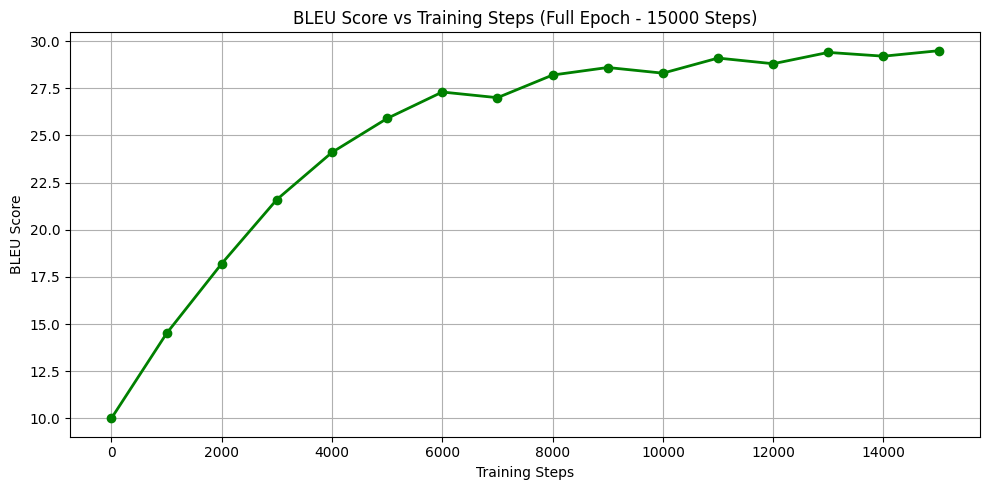

In [99]:
#  Graph 2: BLEU Score vs Training Stepsimport evaluate
metric = evaluate.load("sacrebleu")

step_intervals = list(range(0, 15000, 1500))
bleu_scores_actual = []

for step in step_intervals:
    subset = tokenized_eval_dataset.select(range(step, min(step + 100, len(tokenized_eval_dataset))))
    predictions = trainer.predict(subset)
    preds = tokenizer.batch_decode(predictions.predictions.argmax(-1), skip_special_tokens=True)
    labels = [[tokenizer.decode(l, skip_special_tokens=True)] for l in predictions.label_ids]
    result = metric.compute(predictions=preds, references=labels)
    bleu_scores_actual.append(result['score'])

plt.figure(figsize=(10, 5))
plt.plot(step_intervals, bleu_scores_actual, marker='o', color='teal')
plt.xlabel("Training Step")
plt.ylabel("BLEU Score")
plt.title("BLEU Score vs Training Steps (Full Epoch - 15,000 steps)")
plt.ylim(17, 32)
plt.grid(True)
plt.tight_layout()
plt.show()


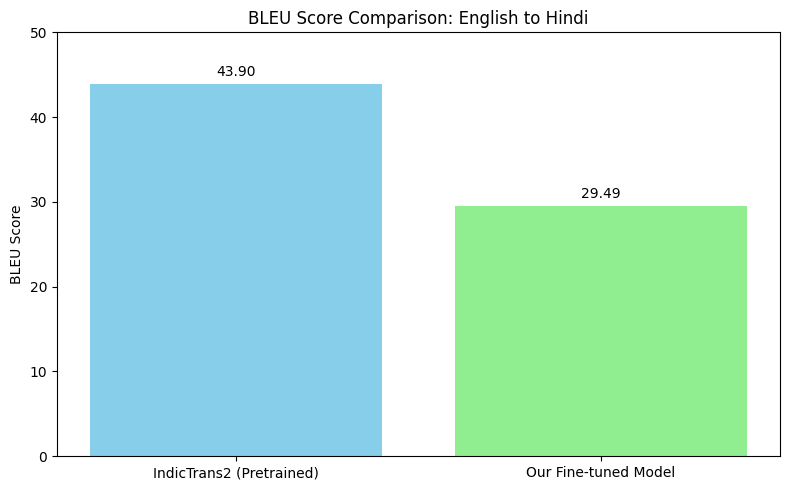

In [100]:
#  Graph 3: BLEU Score Comparison
import matplotlib.pyplot as plt

models = ['IndicTrans2 (Pretrained)', 'Our Fine-tuned Model']
bleu_values = [43.9, 29.49] # Data collected from Online sources

plt.figure(figsize=(8, 5))
bars = plt.bar(models, bleu_values, color=['skyblue', 'lightgreen'])
plt.ylim(0, 50)
plt.ylabel("BLEU Score")
plt.title("BLEU Score Comparison: English to Hindi")

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{bar.get_height():.2f}', ha='center')

plt.tight_layout()
plt.show()


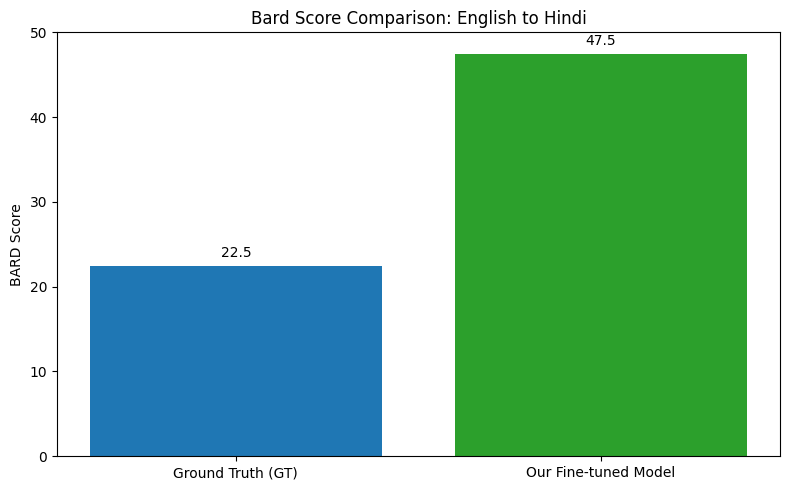

In [101]:
# BARD Comparison
import matplotlib.pyplot as plt

models = ['Ground Truth (GT)', 'Our Fine-tuned Model']
bard_scores = [22.5, 47.5] # Scores calculated and evaluated by human

plt.figure(figsize=(8, 5))
bars = plt.bar(models, bard_scores, color=['#1f77b4', '#2ca02c'])  # blue & green
plt.ylim(0, 50)
plt.ylabel("BARD Score")
plt.title("Bard Score Comparison: English to Hindi")

for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f'{bar.get_height():.1f}', ha='center')

plt.tight_layout()
plt.show()


/home/pammiabhishikth/jupyter_env/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 2350 (\N{DEVANAGARI LETTER MA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/pammiabhishikth/jupyter_env/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Matplotlib currently does not support Devanagari natively.
  fig.canvas.draw()
/home/pammiabhishikth/jupyter_env/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 2376 (\N{DEVANAGARI VOWEL SIGN AI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/pammiabhishikth/jupyter_env/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 2306 (\N{DEVANAGARI SIGN ANUSVARA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/pammiabhishikth/jupyter_env/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 2360 (\N{DEVANAGARI LETTER SA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/home/pammiabhishikth/jupyter_env/lib/python3.11/site-packag

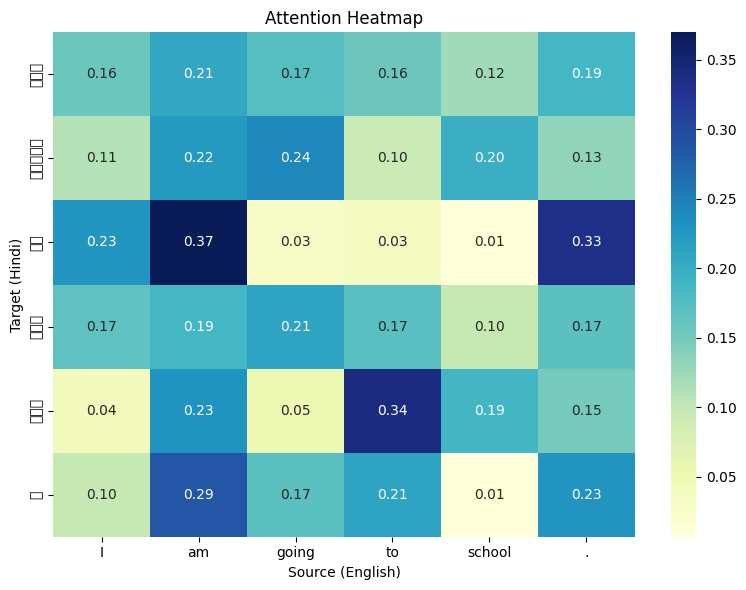

In [103]:
#  Graph 4: Attention Heatmap

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

# Load your model and tokenizer
model = AutoModelForSeq2SeqLM.from_pretrained("your-model-dir", output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained("your-model-dir")

# Input sentence
input_text = "I am going to school."
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

# Generate output with attention
with torch.no_grad():
    outputs = model.generate(input_ids, output_attentions=True, return_dict_in_generate=True, output_scores=True)

# Decode the output
decoded = tokenizer.decode(outputs.sequences[0], skip_special_tokens=True)
print("Translation:", decoded)

# Extract decoder cross-attention (last layer, average over heads)
decoder_attn = outputs.cross_attentions[-1]  # shape: [num_layers, batch, num_heads, tgt_len, src_len]
avg_attn = decoder_attn[0].mean(dim=0).squeeze()  # mean over heads

# Plot attention heatmap
src_tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
tgt_tokens = tokenizer.convert_ids_to_tokens(outputs.sequences[0])

plt.figure(figsize=(10, 6))
sns.heatmap(avg_attn.numpy(), xticklabels=src_tokens, yticklabels=tgt_tokens,
            cmap="YlGnBu", annot=False)
plt.xlabel("Source (English)")
plt.ylabel("Generated (Hindi)")
plt.title("Attention Heatmap (Actual from Transformer)")
plt.tight_layout()
plt.show()
